In [1]:
!pip install -q mlflow

In [2]:
import numpy as np
import cv2
import os
from tqdm import tqdm
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.layers import * 
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import tensorflow.compat.v1.keras.backend as K
tf.compat.v1.disable_eager_execution()
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import mlflow 
import mlflow.tensorflow
%matplotlib inline

2021-09-20 09:26:45.713892: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [3]:
image_path = '../input/chest-xray-masks-and-labels/Lung Segmentation/CXR_png/'
images = os.listdir(image_path)

In [4]:
def get_data(dim = 256):
    im_array = []
    shape = (dim, dim)
    # X_shape = image_size
    for i in tqdm(images): 

        # im.shape = (X_shape, X_shape, 1)
        im = cv2.imread(os.path.join(image_path, i))
        im = cv2.resize(im, shape)[:, :, 0]
        
        im_array.append(im)

    im_array = np.array(im_array).reshape(len(im_array), dim, dim, 1)

    return im_array

In [5]:
X = get_data()
print(X.shape)

100%|██████████| 800/800 [02:30<00:00,  5.32it/s]

(800, 256, 256, 1)


In [6]:
X = X / 255.
X = np.float32(X)

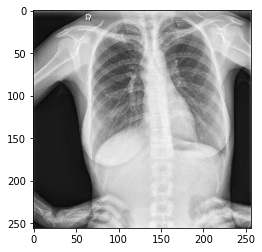

In [7]:
plt.imshow(X[87], cmap='gray')

In [8]:
input_shape = (256, 256, 1)

In [9]:
latent_dim = 2

input_img = Input(shape=input_shape, name='encoder_input')
x = Conv2D(16, (3, 3), padding='same', activation='relu')(input_img)
x = Conv2D(32, (3, 3), padding='same', activation='relu',strides=(2, 2))(x)
x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)

conv_shape = K.int_shape(x) 
x = Flatten()(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.1)(x)

z_mu = Dense(latent_dim, name='latent_mu')(x)
z_sigma = Dense(latent_dim, name='latent_sigma')(x)


def sample_z(args):
    z_mu, z_sigma = args
    eps = K.random_normal(shape=(K.shape(z_mu)[0], K.int_shape(z_mu)[1]))
    return z_mu + K.exp(z_sigma / 2) * eps

z = Lambda(sample_z, output_shape=(latent_dim, ), name='z')([z_mu, z_sigma])
encoder = Model(input_img, [z_mu, z_sigma, z], name='encoder')

2021-09-20 09:29:21.647096: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-09-20 09:29:21.650435: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-09-20 09:29:21.690531: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-20 09:29:21.691262: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2021-09-20 09:29:21.691354: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-09-20 09:29:21.718163: I tensorflow/stream_executor/platform/def

In [10]:
print(encoder.summary())

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 160         encoder_input[0][0]              
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 32) 4640        conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 64) 18496       conv2d_1[0][0]                   
____________________________________________________________________________________________

In [11]:
decoder_input = Input(shape=(latent_dim, ), name='decoder_input')

x = Dense(conv_shape[1] * conv_shape[2] * conv_shape[3], activation='relu')(decoder_input)
x = Dropout(0.1)(x)
x = Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(x)

x = Conv2DTranspose(64, (3, 3), padding='same', activation='relu',strides=(2, 2))(x)

x = Conv2DTranspose(1, (3, 3), padding='same', activation='sigmoid', name='decoder_output')(x)

decoder = Model(decoder_input, x, name='decoder')
decoder.summary()
z_decoded = decoder(z)

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 2)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2097152)           6291456   
_________________________________________________________________
dropout_1 (Dropout)          (None, 2097152)           0         
_________________________________________________________________
reshape (Reshape)            (None, 128, 128, 128)     0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 256, 256, 64)      73792     
_________________________________________________________________
decoder_output (Conv2DTransp (None, 256, 256, 1)       577       
Total params: 6,365,825
Trainable params: 6,365,825
Non-trainable params: 0
_________________________________________________

In [15]:
class CustomLayer(tensorflow.keras.layers.Layer):

    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        
        recon_loss = tensorflow.keras.metrics.binary_crossentropy(x, z_decoded)
        
        kl_loss = -5e-4 * K.mean(1 + z_sigma - K.square(z_mu) - K.exp(z_sigma), axis=-1)
        return K.mean(recon_loss + kl_loss)
    
    def dice_coef_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        intersection = K.sum(x * z_decoded)
        return 1 - (2. * intersection + 1) / (K.sum(x) + K.sum(z_decoded) + 1)
    
    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss1 = self.vae_loss(x, z_decoded)
        loss2 = self.dice_coef_loss(x, z_decoded)
        self.add_loss([loss1, loss2], inputs=inputs)
        return x

In [16]:
mlflow.autolog()

2021/09/20 09:29:58 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2021/09/20 09:29:58 INFO mlflow.tracking.fluent: Autologging successfully enabled for tensorflow.


In [17]:
y = CustomLayer()([input_img, z_decoded])

In [18]:
vae = Model(input_img, y, name='VAE')

vae.compile(optimizer='adam', loss='mse', metrics=['acc'])
vae.summary()

Model: "VAE"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 160         encoder_input[0][0]              
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 32) 4640        conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 64) 18496       conv2d_1[0][0]                   
________________________________________________________________________________________________

In [19]:
res = vae.fit(X, X, epochs = 50, batch_size = 32)

Train on 800 samples


2021-09-20 09:30:17.459260: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-09-20 09:30:17.459629: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-09-20 09:30:17.460031: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-20 09:30:17.460853: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2021-0

Epoch 1/50


2021-09-20 09:30:22.944723: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-09-20 09:30:23.720687: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2021-09-20 09:30:23.765944: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


800/800 [==============================] - 15s 19ms/sample - loss: 1.0735 - acc: 0.0338
Epoch 2/50
800/800 [==============================] - 7s 9ms/sample - loss: 0.9458 - acc: 0.0338
Epoch 3/50
800/800 [==============================] - 7s 9ms/sample - loss: 0.9006 - acc: 0.0338
Epoch 4/50
800/800 [==============================] - 7s 9ms/sample - loss: 0.8887 - acc: 0.0338
Epoch 5/50
800/800 [==============================] - 7s 9ms/sample - loss: 0.8831 - acc: 0.0338
Epoch 6/50
800/800 [==============================] - 7s 9ms/sample - loss: 0.8780 - acc: 0.0338
Epoch 7/50
800/800 [==============================] - 7s 9ms/sample - loss: 0.8780 - acc: 0.0338
Epoch 8/50
800/800 [==============================] - 7s 9ms/sample - loss: 0.8736 - acc: 0.0338
Epoch 9/50
800/800 [==============================] - 7s 9ms/sample - loss: 0.8707 - acc: 0.0338
Epoch 10/50
800/800 [==============================] - 7s 9ms/sample - loss: 0.8692 - acc: 0.0338
Epoch 11/50
800/800 [=================

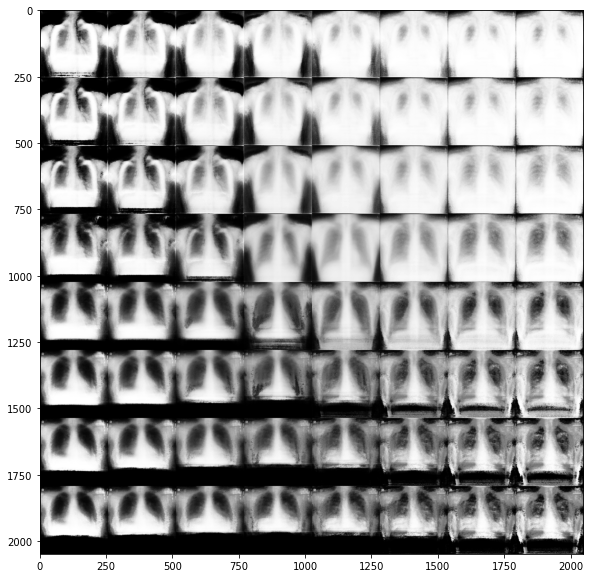

In [26]:
n, i = 8, 8
dim = 256
figure = np.zeros((dim * n, dim * n, 1))

grid_x = np.linspace(-i, i, n)
grid_y = np.linspace(-i, i, n)[::-1]

# decoder for each square in the grid
for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(dim, dim, 1)
        figure[i * dim: (i + 1) * dim,
               j * dim: (j + 1) * dim] = digit

plt.figure(figsize=(10, 10))
#Reshape for visualization
fig_shape = np.shape(figure)
figure = figure.reshape((fig_shape[0], fig_shape[1]))

plt.imshow(figure, cmap='gray')
plt.show() 

In [21]:
decoder.save_weights("decoder.hdf5")

In [22]:
decoder.save("cxr_vae.h5")

In [23]:
from IPython.display import FileLink
FileLink(r'cxr_vae.h5')

/kaggle/working/cxr_vae.h5